# ARIMA Model Price Forecasting
- Acurate for predictions at most 2 days out, assuming volatility is low for those days

In [1]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
#https://www.kaggle.com/code/bogdanbaraban/ar-arima-lstm#ARIMA-model
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Moving Average (MA) Experiment

In [25]:
# Read the CSV file
data = pd.read_csv('prices_and_volforecast.csv')

symbols = data['symbol'].unique()

ma_days = {10, 20, 30}

for sym in symbols:
    ma = {}
    for days in ma_days:
        col_name = f"{days}-Day MA"
        data.loc[data['symbol'] == sym, col_name] = data.loc[data['symbol'] == sym, 'close'].rolling(days).mean()

data

,date,symbol,open,close,low,high,volume,returns,forecasted_volatility,10-Day MA,20-Day MA,30-Day MA
0,2010-01-04,CMCSA,16.750000,16.969999,16.750000,17.129999,13573400.0,1.313427,0.000000,NaN,NaN,NaN
1,2010-01-04,DIS,32.500000,32.070000,31.870001,32.750000,13700400.0,-1.323077,0.000000,NaN,NaN,NaN
2,2010-01-04,NFLX,55.519999,53.479999,52.960001,55.730000,17239600.0,-3.674352,0.000000,NaN,NaN,NaN
3,2010-01-05,CMCSA,16.930000,16.740000,16.549999,16.980000,17746500.0,-1.122268,1.217848,NaN,NaN,NaN
4,2010-01-05,DIS,32.070000,31.990000,31.700001,32.160000,10307700.0,-0.249454,0.536811,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5281,2016-12-29,DIS,104.230003,104.559998,103.870003,104.769997,5892000.0,0.316603,0.789655,104.922000,103.4735,101.879334
5282,2016-12-29,NFLX,125.949997,125.330002,124.199997,126.139999,3443700.0,-0.492255,1.745248,125.703001,124.0175,121.610667
5283,2016-12-30,CMCSA,69.949997,69.050003,68.930000,70.050003,12188400.0,-1.286625,1.021556,70.398000,69.8515,69.567333
5284,2016-12-30,DIS,104.570000,104.220001,103.959999,105.000000,6629500.0,-0.334703,0.778195,104.905000,103.7375,102.049333


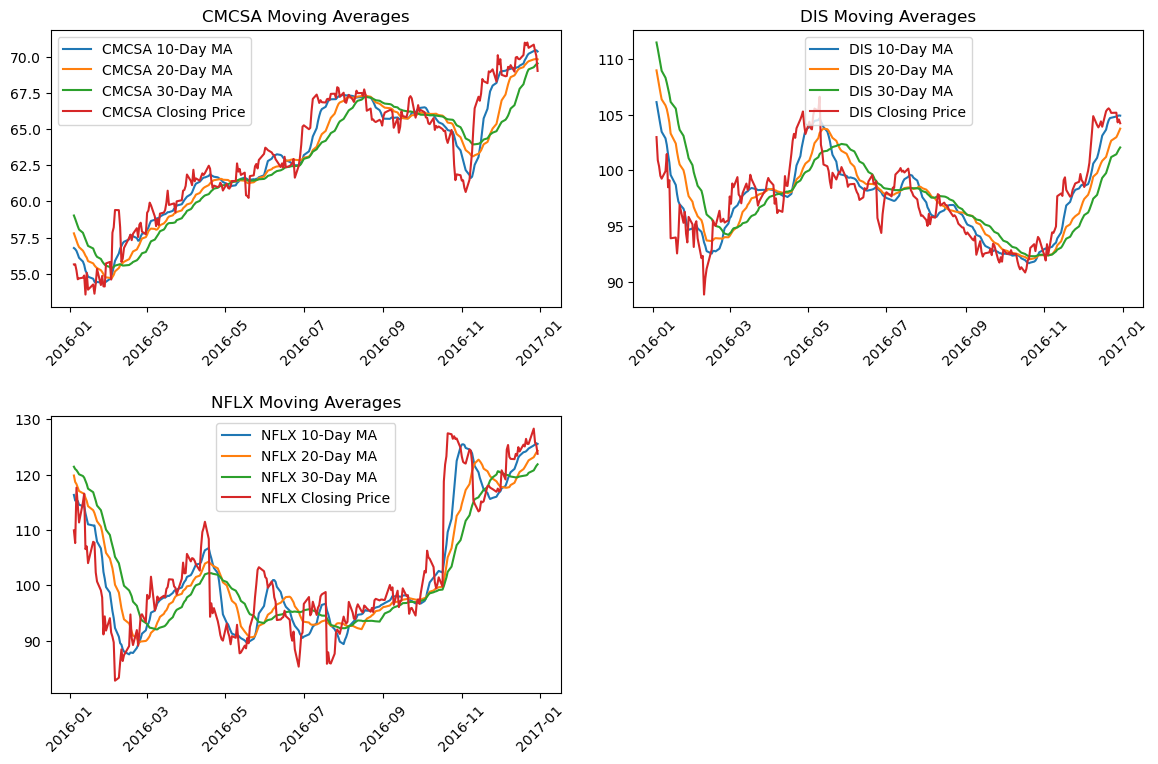

In [28]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over symbols and plot data
for i, symbol in enumerate(symbols):
    symbol_data = data[data['symbol'] == symbol]
    symbol_data = symbol_data.iloc[-252:]  # Just 1 years worth, to see difference in prediction windows. Assuming 252 trading days in a year
    dates = pd.to_datetime(symbol_data['date'], format='%Y-%m-%d')
    
    # Plot 1 day MA
    oneday, = axes[i // 2, i % 2].plot(dates, symbol_data['10-Day MA'], label=f'{symbol} 10-Day MA')
    # Plot 10 day MA
    tenday, = axes[i // 2, i % 2].plot(dates, symbol_data['20-Day MA'], label=f'{symbol} 20-Day MA')
    # plot 30 day MA
    thirtyday, = axes[i // 2, i % 2].plot(dates, symbol_data['30-Day MA'], label=f'{symbol} 30-Day MA')
    #plot close price
    close, = axes[i // 2, i % 2].plot(dates, symbol_data['close'], label=f'{symbol} Closing Price')
    # Set subplot title
    axes[i // 2, i % 2].set_title(f'{symbol} Moving Averages')
    # Add legend
    axes[i // 2, i % 2].legend()
    # Rotate x-axis labels for better visibility
    axes[i // 2, i % 2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout(pad=2.0)

# Hide unused plot
axes[1,1].set_visible(False)

# Show the plot
plt.show()

In [29]:
# add all info to new csv
data.to_csv('prices_ma_and_volforecast.csv', index=False)

# ARIMA Experiment

In [3]:
# Function to calculate ARIMA at every time stamp for every ticker
def predict_ARIMA_for_ticker(train_data, test_data):
    # Group data by ticker symbol
    grouped_data = data.groupby('symbol')
    for ticker, ticker_data in grouped_data:
        history = train_data[train_data['symbol'] == ticker]['open'].values.tolist()
        y = test_data[test_data['symbol']==ticker]['open'].values.tolist()
        # making prediction
        predictions = []
        model = ARIMA(history, order = (1,1,0))
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0] 
        predictions.append(y_pred)
        history.append(y[0])
        #roll preds
        for i in range(1,len(y)):
            model = ARIMA(history, order=(1,1,0))
            model_fit = model.fit()
            y_pred = model_fit.forecast()[0]
            predictions.append(y_pred)
            history.append(y[i])
        
        
    return y, predictions

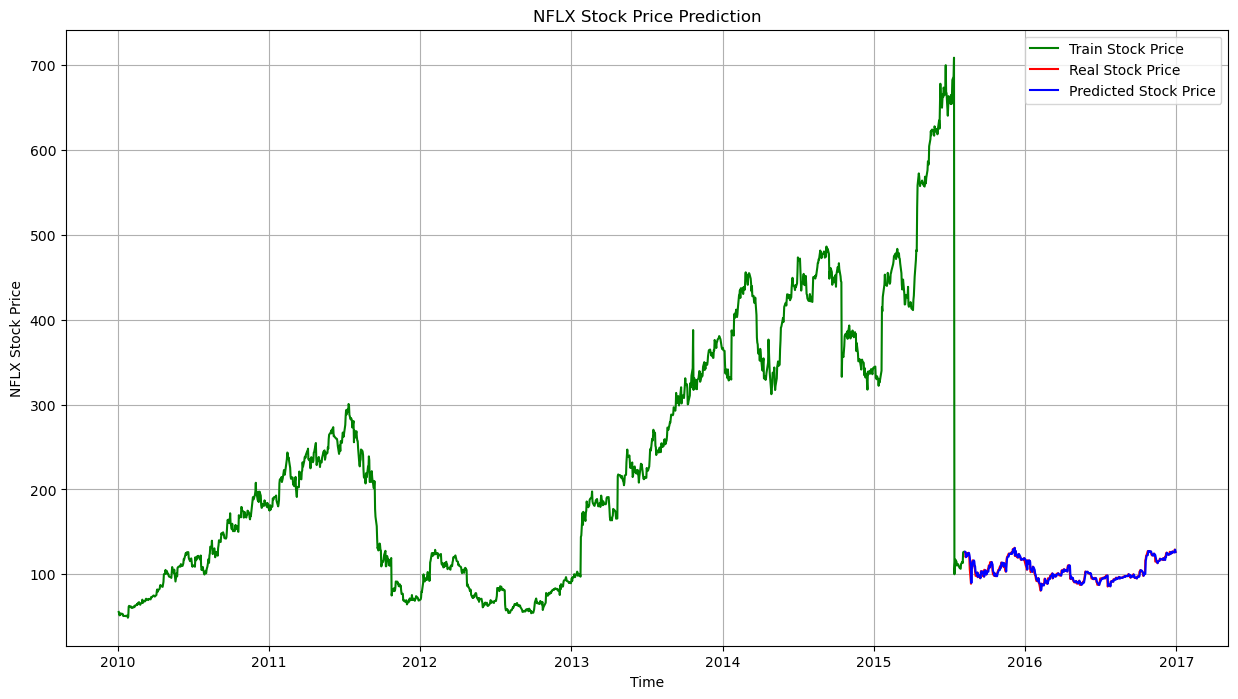

In [6]:
dates_tr = pd.to_datetime(train_data['date'], format='%Y-%m-%d')
dates_tst = pd.to_datetime(test_data['date'], format='%Y-%m-%d')
dates = pd.to_datetime(data['date'], format = '%Y-%m-%d')
plt.figure(figsize=(15,8))

# Plotting train stock price
plt.plot(dates_tr, train_data['open'], color='green', label='Train Stock Price')

# Plotting real stock price
plt.plot(dates_tst, y, color='red', label='Real Stock Price')

# Plotting predicted stock price
plt.plot(dates_tst, preds, color='blue', label='Predicted Stock Price')

# Adding title and labels
plt.title(f"{data['symbol'].iloc[0]} Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel(f"{data['symbol'].iloc[0]} Stock Price")

# Adding legend
plt.legend()

# Adding grid

plt.grid(True)
plt.show()

Drastic dropoff in price in 2014 from AAPL's 7-1 share split in Jun 2014

In [7]:
import math
mse = mean_squared_error(y, preds)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, preds)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, preds))
print('RMSE: '+str(rmse))

MSE: 11.092963711725172
MAE: 2.1573955498172945
RMSE: 3.3306101110344892


In [8]:
model = ARIMA(data['open'], order=(1, 1, 0))  # Adjust order as needed
model_fit = model.fit()
print(model_fit.forecast(steps=5))

1762    126.223904
1763    126.224797
1764    126.224748
1765    126.224750
1766    126.224750
Name: predicted_mean, dtype: float64


C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarni